<a href="https://colab.research.google.com/github/ppijbb/NLP_study/blob/main/drake_lyrics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install watermark 
!pip install transformers
%load_ext watermark
%watermark -v -p numpy,scipy,sklearn,pandas,matplotlib

  Found existing installation: importlib-metadata 3.7.0
    Uninstalling importlib-metadata-3.7.0:
      Successfully uninstalled importlib-metadata-3.7.0
     |████████████████████████████████| 1.9MB 18.7MB/s 
     |████████████████████████████████| 3.2MB 57.0MB/s 
     |████████████████████████████████| 890kB 27.6MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=5211afba7f708b9e8867627aaca2fbaa27c0489c7144be856e92859030df0010
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
Python implementation: CPython
Python version       : 3.7.10
IPython version      : 5.5.0

numpy     : 1.19.5
scipy     : 1.4.1
sklearn   : 0.0
pandas    : 1.1.5
matplotlib: 3.2.2



In [2]:
import numpy as np
import os
import time
import datetime
import torch
from tqdm import tqdm
import subprocess
import os
import re
import argparse
from torch.utils.data import DataLoader # 데이터로더
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib 
import pandas as pd
import matplotlib.image as mpimg
from pandas.plotting import scatter_matrix
import seaborn as sns
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)
import random
from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup


plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# 한글출력
matplotlib.rc('font', family='Malgun Gothic') # 기본 폰트인 맑은 고딕을 사용함.
plt.rcParams['axes.unicode_minus'] = False

# 그림을 저장할 폴더
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "final_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

# 그림을 저장하는 함수
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
drake = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/data/drake_data.csv', encoding = 'utf-8')
drake = drake.dropna(axis=0)
temp = []
for lyric in drake['lyrics']:
  temp.append(lyric.split('\n'))
for verse in temp:
  for line in verse:
    if line == '' or len(line)==0:
      temp[temp.index(verse)].remove(line)

lyric_list = []
for verse in temp:
  line_t=''
  for line in verse:
    if line[0]=="[":
      temp[temp.index(verse)].remove(line)
    else:
      line_t = line_t+line+'. '
  lyric_list.append(line_t)

In [4]:
list_df = pd.DataFrame(lyric_list)

In [5]:
bios = list_df[0].copy() #just use the main bio text in this example
bios

0      Always been a gem. Certified lover boy, someho...
1      Someone's in my ear from the other side. Telli...
2      Wassup ladies?. Swishahouse, baby. Wassup to a...
3      Pipe this shit up and I turn this shit up. Whe...
4      I tell ya, "I stopped keeping count when I was...
                             ...                        
266    You know that you got me. You got me where you...
267    Uh. I just hope you stay down, uh. I just hope...
268    You's a vegan but you goin' ham. Lotta niggas,...
269    Oh-oh-oh-oh. You and your girlfriend too badmi...
270    And I know. I just want the top, don't wanna c...
Name: 0, Length: 271, dtype: object

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Malgun Gothic'] not found. Falling back to DejaVu Sans.


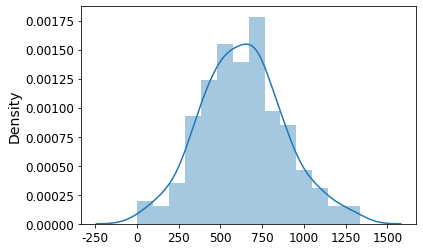

In [6]:
import nltk
nltk.download('punkt')


doc_lengths = []

for bio in bios:

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

doc_lengths = np.array(doc_lengths)

sns.distplot(doc_lengths)

In [7]:
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

0.2730627306273063

In [8]:
np.average(doc_lengths)

633.6236162361623

In [9]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2-medium

Special tokens have been added in the vocabulary, make sure the associated word embedding are fine-tuned or trained.


In [32]:
batch_size = 2

In [33]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

In [34]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.85 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  230 training samples
   41 validation samples


In [35]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [36]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
# some parameters I cooked up that work reasonably well
epochs = 40
learning_rate = 5e-5
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [38]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [39]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [40]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [41]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 300,
                                    top_p=0.95, 
                                    num_return_sequences=5
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 40 ========
Training...


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 4.109401226043701.   Elapsed: 0:00:59.
0:  bipartisan, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the,, of the,, of the, of the, of, of the, of the, of the, of the,,, of the,, of the, of the, of the, of the, of the, of the, of, of the,,, of, of the, of the,, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of the, of,,,, of the,,, of the
1:  bipartisan, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the,, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 4.21872615814209.   Elapsed: 0:00:58.
0:  increasing in the number of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number number are numbers of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number of times some number are number number are numbers number are numbers there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, number are number are numbers there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there, there

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.7659897804260254.   Elapsed: 0:00:58.
0: day is time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time is the time i

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.8388874530792236.   Elapsed: 0:00:57.
0:  Hang ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back year) ( me back ( year) ( me back year year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back ( year) ( me back year) ( me back year) ( me back ( year) ( me back ( year) ( me back year) ( me back ( year) ( me back
1:  Hangy. But yeah yeah I'm serious.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.7958452701568604.   Elapsed: 0:00:58.
0:  foodsYou can't live without us, we'll never touch your shit you know. You're just as bad with the shit you do. You're just as bad with the shit you do. You're just as bad with the shit you do. You've been here, you've been here. You're just as good as nobody else got to be. You're just as good as somebody else got to be.
1:  foods. it's your friend. You are my roommate. You think I am just a person. You really are a real person. You think I am just a person that I am. I don't even do your work. I never do your work. I don't even do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I don't even do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your work. I never do your wo

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.3018791675567627.   Elapsed: 0:00:58.
0:  trail. c. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me. me.              
1:  trail in year, for the first time, I just got the first year of the year. They told me that I was too old for that. And the first thing I said was 'No, I'm not young. I'm not young, I'm not young, I'm not young. And I'm not young, I'm not young, I'm not young, I'm not young, I'm not young. And I'm not young, I'm not young. And I'm not

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.4693868160247803.   Elapsed: 0:00:58.
0: intend
 it's hard to to you, and I feel like the world just keeps changing, and I always wanted to do everything just for me. I think that's when it's harder than it used shit, and it just ain't got no place like it belongs. I don't know what to do, that's a lie to me. Yeah, even though it took a while to get to where I was, I'm still so attached. I'm still trying to figure that out though. And yeah, it's just one of those things where you gotta deal with it, you gotta deal with it. And yeah, that's like, no one will ever know you're the way you wish you was, but it won't happen. No one will ever say you were the way you wish you was. Yeah, even though it took a while to get to where I was, I'm still so attached. I'm still trying to figure that out though. And yeah, it's just one of those things where you gotta deal things, you gotta deal with them. And yeah, that's like, no one will ever know you're the way you

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.2112261056900024.   Elapsed: 0:00:58.
0:  surround " things that are so good! " -- The introspection of the introspection of my soul. " -- What's the difference between a man and a woman?. " -- The newness and the newness of my vision. " -- How much world I live with. " -- When I start to lose patience. " -- What is my relationship with my God?. " -- When I wake up in the morning and all I think is is " I know how to make my brother feel good. " -- When I lose the energy you're problem. " -- A man that tells me that I need it all. " -- When I lose your faith in you, I will ask you to return it, but you will never find me. " -- The question is, "How can you return to that dream you mommy dream?. " -- The question is, "Who is this girl on the other side?. " -- The question is, "How can you bring yourself to accept that you have a problem?. " -- The question is, "Who is this girl?. " -- The question is, "What the fuck is it about?. " -- The question is, "

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.209312915802002.   Elapsed: 0:00:58.
0:  reflex in while still getting, but then when I do, my brother-in basement, my mom just tells me, "You know I'm the real deal. You know we are the real deal. You know I got the real deal. And you know I got the real deal. It's just like you. You know I got the real deal. I got the real deal. I got the real deal. All I need is the real deal. And I'll see it through the lens, right? I guess this way you see it, yes. I guess this way you see it, yes. I guess this way you see it, yes. I guess this way you see it, yes. I guess this way you see it, yes. I guess this way you see it, yes. I guess this way you see it, yes.
1:  reflex,, goo, goo, goo, goo, goo, goo, goo. You gotta go, go, go, goo, goo, goo, goo, goo. You gotta go, go, go, go, go, go.  This shit ain't even real.  No-one wanna hear shit like this, no-one wanna.  ass ain't real.    ‘I'm all in that car right now.   ‘All in that car right now.   ‘Fuck this shi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.8191601037979126.   Elapsed: 0:00:58.
0:  display,, and you should be there too. And yeah, if anybody ever something that I might do I'd do that. And yeah, yeah, that's what everybody should do for them. And yeah, that's what everybody should do. And yeah, that's what everybody should do. And yeah, that's what they should do. And yeah, that's what they should do. And yeah, that's what they should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yeah, that's what you should do. And yea

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.5607004165649414.   Elapsed: 0:00:58.
0:  pastor. person, I'm going to be there. my momma love me and now I'm the center. that's the definition of love. I'm just like the sun in my skin. My mother never gave a fuck about me. Don't get your mother out of my life, this chick ain't got no fuckin' left on her to do with it. But if I'm still with you, we can go on. We gotta love each other. We gotta grow. We gotta get the confidence that we gotta grow. It's not my fault, she did bad things. But we just gotta be thankful for what we got here. I mean look at the world and I swear, these days that I'm with a nigga ain't that long. You see it's just the nigga I'm in this for. I don't even care, that's like one of those black dudes. They just wanna make me feel better. Like that's how they make me feel. But you know what I mean? I got a lil boy in this for and now I'm the center. I just wanna stay. I'll let my mother make decisions that'll make me happier. All t

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 3.127382755279541.   Elapsed: 0:00:58.
0:  illicit the and that's really good, man," voice on the mic said. "I need more money to do these things. I need more money to get it done. That's really good, man. And maybe we'll even have one more year or two and we'll be in the same city or something. We should know that. And maybe we'll just have some more money to do these things. That's really good, man. And maybe we'll even have some more money to do these things. That's really good, man. And maybe we'll even have some more money to do these things. That's really good, man. And maybe we'll even have some more money to do these things. That's really good, man. And maybe we'll even have some more money to do these things. That's really good, man. And maybe we'll even have some more money to do these things. That's really good, man. And maybe we'll even have some more money to do these things. That's really good, man. And maybe we'll even have some more money

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.368633985519409.   Elapsed: 0:00:58.
0:  LiberationWe (I'm just trying to stay alive). We don't need you (Love me, Baby). Yeah, I know. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. I know how that feels. 
1:  Liberation.—and I want—a—bunch of people—who are—just—the ones I—was—the shit. (Tippin'), that's for real, the nigga. That's what we do—in real life, I'm not, yeah. I'm a young black man, don't be mean, do you want me, do ya. I'm the motherfuckin' bitch that made you—you're the one that said you could—you made it. That's a nigga. I'm still trying to figure out wh

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.5432307720184326.   Elapsed: 0:00:58.
0:  NamMate, look! I heard from the old nigga, niggas ain't got nothing like it, I'm too old for this shit. Cause what the fuck is with this? A nigga from Poland, we don't come together like it and shit. Y'all up in these vans, they just beakin' like you did. They ain't no no show, they ain't no star. Like if you can't prove yourself, you can't prove yourself, so we never callin' you back, no shit. Cause I ain't no nigga here to judge, no man, I ain't a man. Niggas, you know what we do, they don't even listen to a nigga's opinion. They just talkin' and bein' dumb, so that's why I don't tryna do so much. So when you come from the south, when you get your girl, you get the boy. Yeah, that's where we can make it. We don't make it here either, we make it here, then we make it, then we make it, then we make it, then we make it, then we make it, then we make it, then we make it, then we make it, then we make it, then we 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.322636365890503.   Elapsed: 0:00:58.
0: IONIn the beginning there was hope that they would come together, that people would meet them. But they have always been different. They are brothers that I will never know. 
1: IONS, MESSH, VANILLA TOY MO MO, HIVEC, LIVEC; SIXTH PENAMENT, HOOP HAPPY BECOME MIXTER, LIVEC. PENTATO, PEGGORI, MIXTER NIGGA; SIXTER SIXTER TO SEE, LIVEC, NIGGA. HOOHOO, MIXTER NIGGA, HOOHOO. YELLOW LIGHTS, MIXTER NIGGA. PECATO, LIVEC, MIXTER NIGGA. NIGGA, HOOP HOOP. MIXTER HOOHOO, HOOP HOOHO. LIVEC, HOOP LIVEC, HOOP HO. HOOHOO, HO HOOHO. IOLA NIGGA, HOOP HOOHOO. FISH PENTATO, PEGGORI, MIXTER MIXTER. PENTATO, PEGGORI, MIXTER MO. OVO, PEGGORI, MIXTER NIGGA. OVO, PEGGORI, MIXTER NIGGA. OVO, PEGGORI, MIXTER NIGGA. PENTATO, PEGG MO, HOOP HAPPY BECOME GIGGA. HOO
2: IONIt's ironic that first lady Melania, first lady, we're going after every rapper, every single girl that wants to be in my city. You know what I mean? You might be one of them gi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.6899194717407227.   Elapsed: 0:00:58.
0:  glimpseThey got the vision of perfectionAnd you're so beautifulI told you to wait, baby, this is what life wasgoing to be like I'mma tell you. I told you I'd never give up, all I've done is be a vessel. I promised myself this would never change, all my life we just stuck around. So don't ever let that kid say, "Damn, look, he looks like a girl". Instead let him say, "I love you all the same, honey". 'Cause you know that I love you all the same, honey. Cause you know that I love you all the same, honey. Cause you know that I love you all the same, honey. If you don't love me, you don't really deserve it. Even if it's just me, even if my love is bad, even if I'mma show it to you. Show it to me every night. Show it to me every night. Show it to me every night. Tell me what is 'til next week. Tell me everything that comes in to my body. Let me see if you're loving me as much as you are. I'mma tell you when you fina

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.9801950454711914.   Elapsed: 0:00:58.
0:  LaureTing It Up.
1:  LaureWoo?. (Ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy, ayy. Yeah, man, whoa, where am I right now?.!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
2:  LaureSki, who never made a scene in her life. I ain't even goin' for it, she said. So I said she would. And now you gon' show her up. Yeah, she said it. And now you're goin' for it. So I said she would. And now you gon' show her up. You got somethin' I need you for. Don't come here without her. You heard her out the rain. I'm still comin' with the women. Let's just get it on. We can't let the girls get a body. An

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.051863431930542.   Elapsed: 0:00:58.
0: ism to money, and I think it's a way to go and it's a struggle to get through it. It's the way to do it. We need your help, and we've seen your problems lately and you need someone else to help with them. We need your help, and we've seen your problems lately and you need somebody else to help with them. We need your help, and we've seen your problems lately and you need somebody else to help with them. We need your help, and we've seen your problems lately and you need someone else to help with them. We need your help, and we've seen your problems lately and you need somebody else to help with them. If you haven't done it, you're dead for it, you're dead for it, you're dead for it. If you haven't done it, you're dead for it, you're dead for it, you're dead for it. We need your help, and we've seen your problems lately and you need somebody else to help with them. We need your help, and we've seen your problems l

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.0341827869415283.   Elapsed: 0:00:58.
0: oun-yell, yep, and I'm back. I'll go, yep, and I'm back. I'll go, yep, and I'm back. I'll go, yep, and I'm back. I'll go, yep, and I'm back. I'll go, yep, and I'm back. Oh ho ho ho. I'm on top of it. Just get the air and make it. Just make sure no one's out there waiting for me. Get the air and make it Pop. And you can get the air just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can get the air just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make it Pop. And you can just make 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 3.4119138717651367.   Elapsed: 0:00:58.
0:  election., they never say. We gotta stay home in this city and get married, I'm with a girl who want me to be. Yeah. We need some time, I'm with a girl who want me to be. I know your heart is in your ears, baby, you know how to get the message across. That's how I hear it from your ear. It's in your ears the same when the news hits the paper. 'Cause this is real, I'm out there right now with no words. The girl I love you is just as beautiful as you are. What's going on around you? I'm out there right now, all alone. You know how to get the message across. That's how I hear it from your ear. It's in your ears the same when the news hits the paper. 'Cause this is real, I'm out there right now, all alone. Yeah. We need some time, I'm with a girl who want me to be. I know your heart is in your ears, baby, you know how to get the message across. That's how I hear it from your ear. It's in your ears the same when the

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.8109924793243408.   Elapsed: 0:00:58.
0:  crazyT. And I don't regret it, just cause it's been a long time since we've done it together. I've got a lot of people I can count on when we're in the car. And when I'm done, they're gone. And you know who you are. I know that if I leave you a better man, I will never forget you. 'Cause we'll never be alone and we'll never be alone. And you'll love my boy if you love me so. Always. And I keep on puttingtin' plans aside so I never really talk. Because it's gotta end soon. And my team got to be together, too. And every time you tryin' to come up with me. I got a real time head, I'ma work it back with you. Every time you tryin' to come up with me. I got a real time head, I'ma work it back with you. Every time you tryin' to come up with me. I got a real time head, I'ma work it back with you. Every time you tryin' to come up with me. I got a real time head, I'ma work it back with you. Every time you tryin' to come 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.5132657289505005.   Elapsed: 0:00:58.
0:  bench. yeah. no. like I'm doing a lot of things wrong. yeah, shit. yeah. yeah, shit. yeah, shit. yeah. yeah, shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit. shit
1:  benchWorst bit

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.4602274894714355.   Elapsed: 0:00:58.
0:  incorporatedThe best is a lie, but I know that it's nothin' that I'm hiding. I've been trying to hold my own all summer, and now my body's too busy to care, and I know what I'm gettin' for Christmas. But these days I'm not even awake, and I don't know what else to do. And if you don't love me, then what you deserve is silence. I guess you have something to hide, don't you, girl?. Maybe a song from the other side, it could bring them closer. But you need to hide all that love, that's just what I do, girl. I can't do that, you're already broke, girl. There's so much more to me than how I live, I don't get that done, girl. I don't even really think about how I do, girl, there's so much more to me than how I live, girl. And your friends telling you I made it, don't give a fuck. Because I don't really want to talk about you, girl. I know how you feel when I touch you, girl, I won't hold you. I'm just tryna hold you 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.281224012374878.   Elapsed: 0:00:57.
0: PeterCrazy? But if my mother's safe, will I be safe? Because if my mother's safe, who knows? Because I don't really have a choice, my mom will tell me. She might say 'I never told, she wouldn't' or it'll change forever. But if my mom is safe, I'll know. She might say 'She's safe, she would love you'. 'Cause she said 'You said you're a patient, I'm not". 'Cause I said things like, 'If you need a moment, put it on hold'. 'Cause it's probably too late to save that moment, so I'll take it. And put it on hold'. And put it on hold. And put it on hold. And put it on hold. 'Cause it's probably too late to save that moment, so I'll take it. 'Cause it's probably too late to save that moment, so I'll take it. 'Cause it's probably too late to save that moment, so I'll take it. 'Cause it's probably too late to save that moment, so I'll take it. 'Cause it's probably too late to save that moment, so I'll take it. I'm not alone.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.6889230012893677.   Elapsed: 0:00:58.
0: uringOn my knees, on my knees. I been waiting on you. Let it feel as if someone's asleep. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you, you know?. Let it get to you,
1: uri

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 3.0512337684631348.   Elapsed: 0:00:58.
0:  reproductiveM lady, I had to give up. I had to accept it. I had to keep it—a hundred thousand for myself—enough for myself. And here we are in a time that's gone, where women are scared to speak in public. And men are afraid to say themselves. I can feel they're scared of not being understood, and fear that they'll never understand. So I had to give up on life and never move on. So I had to give up on my own. I had to give up—a hundred thousand for myself—enough for myself. And here we are in a time that's gone, where women are scared to speak in public. And men are afraid to say themselves. This shit is ridiculous. Women say I love them (loving them) and hate me (niggas hating me). I can't trust her, she won't trust me. If they ever hear that I love them and hate me, they'll hate me too. Why on Earth do we need it this late? If they ever hear that I love them and hate me, they'll hate me too. Why on Earth do w

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.324439525604248.   Elapsed: 0:00:58.
0:  zone6.7.8.9.10.11. I'ma gettin' the info from the safe. I'm a motherfucker. (Wanna come inside?). Don't tell me you wanna dance with the hoes. (Member?). Don't tell me I'm gon' get a glass of Dr. Luke. I just hope the nigga can't find another one to drink with. (Member?). Don't call me "baby". I just hope he can't find another one to drink with. I just hope he can't find another one to drink with. All the women in this city got to experience the pain and it's just a matter of time before the man take down the man. And we'll see if he still alive. So get that ass and that pussy ready for the season. Let the season begin. Let the season begin. Let the season begin. Let the season begin. If you got nothing that you can hold on to, it's kinda hard to hold on. Let's face it, the last thing you wanted to do was move. (Member?). When the season starts, I'ma make it right this year. Don't say it "Baby", I just want you 

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.570889711380005.   Elapsed: 0:00:58.
0:  commitsOn behalf of the people of this land: I testify that the people of this land are the chosen ones. They have my burial memento that I have given them. They have my burial m ring that they gave me. I am the one that sent them the message that I am chosen. So that they might have a better chance at all of being successful. I am a rebel against the wishes of the people I lead. I am a rebel against the desires of the people I lead. So that they might have a better chance at all of being successful. 
1:  commitsIn your heart. I can't see you hurt in your eyes. That'll hurt forever. Please forgive me. I don't see no one. I've been praying for you for a long time. I know you've been praying for me for a long time. Don't forget about me. You've been thinking of me too much and I've been neglecting you. I've been holding you down, I've been feeling so alone, I know you're lonely. Please forgive me. I don't see no o

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.6951316595077515.   Elapsed: 0:00:58.
0:  ironyI need a drink and a toast. Yeah. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. I need a drink and a toast. Ayo. Don't even listen to me. I can do nothing. I need to do nothing. Ayo. Niggas. They be poking fun at me. They be poking fun at me. They be poking fun at me. They be poking fun at me. They be poking fun at me. They be poking fun at me. That's the way it is. That's the way it is. I'm not trying to make a career out of it. I'm not trying to make a career out of it. I'm not trying to make a career out of it. I'm not trying to make a career out of it. I'm not trying to make a career out of

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.3218884468078613.   Elapsed: 0:00:58.
0:  Sah. Aye. He came before the King. Told you everything. Had you my mind?. When the prince told you everything. That's how I got me here. Oh. I don't know who to blame but you. That's when your lies end. Oh. You didn't want to hear it. Oh. My heart hurts. Your laughter isn't enough. Oh. How you always smile. Oh. Who would you think of?. Oh, I guess you could say no. Oh. You can't stand me. I can't stand you. I can't stand you. How you always smile. Oh. Oh. How you always smile. And you can't stand me. Why you always smile when I smile when I smile. I don't understand. You say I look selfish?. Why you always smile when I smile when I smile. Oh. What you say when you smile is wrong?. I don't understand. You say I look selfish?. Why you always smile when I smile when I smile. Oh. What you say when you smile is wrong?. I don't understand. You say I look selfish?. Why you always smile when I smile when I smile. Oh. I

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.2370095252990723.   Elapsed: 0:00:58.
0:  BryanHang on a wire, hang with the Russian mob on fire! — Nicki Minaj’s Reign on a high? — Luke Gallows’.’ — Boi-1da crank, go on the road, come with me on a date! — Lil' Wayne on a mission, Lil' Wayne on fire! — YG on her back, Yo Gotti’! — Young Money on Drake!, Young Money on her back! — Drake, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Drake, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her back! — Young Money, Young Money on her back, Young Money on her ba

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.2543752193450928.   Elapsed: 0:00:58.
0:  spiritsIt was like being kidnapped from the past, but now you're here in your present. (Yup, ayy). We got the money for some drinks, we got some real dough to blow your mind. We're here in this for a reason, you ain't nobody's friend. You gotta go get a job and put on the right attitude. And we say that even when we don't know. Cause the truth is you're way too nice to others. Yeah, you and your accomplices. We had it all on the spot (All you got is the key), 'cause you fuckin' never been the same. So let's start over, we got somethin' you don't need 'til we reach. Let's see if you can take it. Then start over, you better take it (Let's take it). Yeah, this is all for niggas that wanna drop 'em on the spot. We'll do whatever it takes to show you that love is alive. You should drop what you're doing right now (I just wanna get me a drink). Don't ever get back to me, you should drop what you're doing right now. Y

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.128535032272339.   Elapsed: 0:00:58.
0:  sees you bitch, the city's got an addiction to you. Just ask around, you won't get a response. I could pick you up at a party if you're not there for the night. You don't really deserve to be there for the night, I can't stand to see you go. I can't believe you, you're making me mad, you're obsessed with me. But that'll just get you down, then get you back up, then get you back up again. I can't believe it, that'll just get you down, then get you back up again. I can't believe it, that'll just get you down, then get you back up again. That'll just get you down, then get you back up again. I can't believe it, that'll just get you down, then get you back up again. I can't believe it, that'll just get you down, then get you back up again. I can't believe it, that'll just get you down, then get you back up again. I can't believe it, that'll just get you down, then get you back up again. I can't believe it, that'll j

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.077439546585083.   Elapsed: 0:00:58.
0:  hungrySucker!, y'all don't get it. Y'all don't get it. Y'all don't get it. Y'all don't get it. Y'all don't get it. Y'all don't get it. Y'all don't get it. And if they give you the keys, then fuck. Then I see them all but I don't see them. You better fuck with your team, then we'll all know. 
1:  hungryThe ones that you love so much. We want to see you do them thing. We wanna see you do them thing. We wanna see you do them thing. We wanna see you do them thing. We wanna see you do them thing. Yeah. Like. I keep feeling like. "Why won't it be like this?". When. Why won't it be like this?". 
2:  hungry (who's a genius?) to come rescue. And you just told me, "That's a fucking ridiculous question" and "I'ma know". Now you wanna make the song to this song. We're goin' on these drugs runnin' through our town. You've done a number on us. We need a bigger nigga to be like, "Whoa...". And uh, you doin' that one for a livi

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.9368393421173096.   Elapsed: 0:00:57.
0:  PTBiscayne, VA. VA Today, we open up shop. We hope you enjoy. We hope you enjoy. When the clock tickin' and the lights up, you can't help it. And it's true that every time I look up. I know that lookin' up can take years. I'm sayin' I'm ready, you can wait till the end. 'Cause I got a thing for you. My mother always treated me like it was a favor. When she gave the first name to a mascot. And he always came around with it. When she had a diamond ring on her finger. I don't know how the world could forget about it. But he always came around with it and they even showed up in public. He even put on his favorite band for the occasion. And every time he'd come around he always been there. I've known him for twenty-six years. He's never been shy. But at twenty you won't forget him. Cause, uh, there's a good chance he would just forget you. Uh, 'cause you never hear the good things from me. I know he's nervous, but I

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.9011784791946411.   Elapsed: 0:00:58.
0: üPiggas, you look better. Lookin' prettier, oh-oh. Pull up in the truck with my old shit. Pull up right beside me, lookin' like I'm losin' up in Southside. Yeah, I do, I do. But I gotta be a star and a million a week, girl. I'll never change for nothing and everything. I'm tryna see what I'm livin', like I'm on a mission. I've been tryna say thank you, like I'm tryna come. But my momma wanna fuck and then I'm goin' off for the weekend. She never wanna come back but I know. If I'm tryna have a wedding I'll probably regret it. I hope it ain't to one of these days, I'ma have her back on top. That's the reason we even came together. And then we went down a shit. Back when you were all about to turn 30. All these niggas started thinkin' about all this money. The only difference was your father never paid. I feel like I'm tryna go against you. And I'll be tryna show you everything I know and all I do is act like. Yeah

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.1456637382507324.   Elapsed: 0:00:58.
0: ruceYou’re’a’paper cuttin' on me, yeah. If you wanna fuck me, you need to wait for somebody else. I'm outta here right now, I swear, baby, I'm in a relationship right now. I'm on some other shit. I'm feeling down right now, I'm on some other shit. I’m from Florida. And I said "enough already, enough," you know?. Cause if anything good ever comes to you. That's all I wanna do, baby. Give it all I got, I'll be back with you (I’m not gonna lie). I hope you stay faithful to me, baby. I said "enough already, enough," you know?. Cause if anything good ever comes to you. That's all I wanna do, baby. Give it all I got, I'll be back with you (I’m not gonna lie). I hope you stay faithful to me, baby. I said "enough already, enough," you know?. Cause if anything good ever comes to you. That's all I wanna do, baby. Give it all I got, I'll be back with you (I’m not gonna lie). 
1: ruce(r). Ayy. Man. See you later, everybody.

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.4970505237579346.   Elapsed: 0:00:58.
0:  derivativesIt (mind blown) don't want you. They want all the credit for what you do. I know this shit is not for everybody. Just sayin' a word, and that's okay. You're too busy man, you know it. That's when I say, "You've been caught up in this drama, I should've known sooner". I think, well, I guess I should've kept up with you for as long as I was with you. But I had to give you time so. So much, you never see me get to my face. And how is that for you?. How is that for you?. How is that for you?. You know what's wrong with me?. But let me do my best and let you know what it is. 'Cause you know what's wrong with me?. But let me do my best and let you know what it is. Let me do my best and let you know what it is. I wanna change, I wanna change. Let me do my best and let you know what it is. You can change, I can change. I know it's rough, but, for all of me, you ain't had no time to make me change. Don't call

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 1.7283316850662231.   Elapsed: 0:00:58.
0: WOO-WOO-WOO! (Uh-huh) You just know what I'm about (Uh-huh). Just know what I'm about, yeah. You just know what I'm about, uh. Just know what I'm about, yeah. This is like we did it twice already. Just know what I'm about. Just know what I'm about, yeah. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. I don't love you like you love me. Oh-oh. So you wanna save your ass. Yeah, you don't wanna give a fuck. Yeah, you don't wanna give a fuck. Yeah, you don't wanna give a fuck. Yeah, you don't wanna give a fuck. Yeah, you don't wanna give a fuck. Yeah, you don't wanna give a fuck. You know what I'm about. (Uh-huh) All right you can say. All right you can

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of    115. Loss: 2.044883966445923.   Elapsed: 0:00:58.
0:  rememberingAyy. 
1:  rememberingBut I always feel like I'm on one. When it all gets too much, that's when things come together. I always gotta do my part to keep this forever and never stop feeling. That's why I try and act like it's never going on. Even when I'm in the zone. There's just not enough time. And I still have to do it. It's hard to keep track of how many times it's been. And what I want to say about the day's resolutions. But still here, you stay up at night trying to get to my phone. It's just too late already. It's hard to do all my other things today. Because your body just won't let you get there. I'm in a zone, try and hold up on you. I gotta get it all together, I'm in the zone, try and act like it's never going on. Even when I'm in the zone. There's just not enough time. And I still have to do it. It's hard to keep track of how many times it's been. And what I want to say about the day's reso

In [42]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,15.18,3.97,0:01:12,0:00:04
2,3.00,2.77,0:01:11,0:00:04
3,2.77,2.68,0:01:11,0:00:04
4,2.68,2.61,0:01:10,0:00:04
5,2.62,2.60,0:01:11,0:00:04
6,2.57,2.63,0:01:11,0:00:04
7,2.54,2.56,0:01:11,0:00:04
8,2.50,2.59,0:01:11,0:00:04
9,2.48,2.57,0:01:11,0:00:04


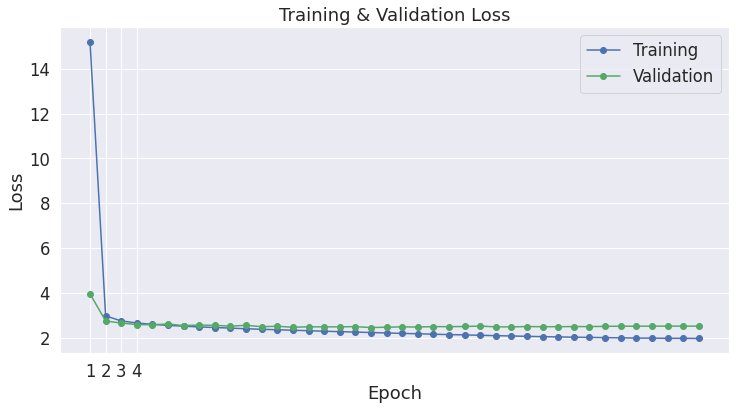

In [43]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [44]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

In [45]:
model.eval()

prompt = "Kimchi"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 50,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[26374, 11072]], device='cuda:0')
0: Kimchi niggas. They gon' know it. I told y'all we need to move outta here now. Tell me we need to move outta here now. I told y'all we need to move outta here


1: Kimchi (x). F.A.I. (x). Energizer bunny. 


2: Kimchi me, jimchi naw. Yeah. I want you to know that I'm a descendant, yes. 


3: Kimchi way. She got so accustomed to all the stuff that we used to do in the club that we girls got used to it. Now we just chill and play the game. I guess it's just me and them all and they


4: Kimchi. I might as well have him here in there, but it's hard to cause he's the one to watch. 


5: Kimchi how's that going for you. So this one's for you. I'ma tryna fix your mind and get you through it. And this one's for you. You're the only one. And you're always the only


6: KimchiTangent, oh. What the hell?. I could feel her heart thumping like I was beating a drum. I bet I could feel her pussy clit, shawty. My daddy's so accustomed to this shit,


7: Ki

-------